# Tutrial of kABC method

In the world of population genetics, a technique called approximate Bayesian computation (ABC) is often used to avoid likelihood when the model is complex.
Kernel Bayesian computation (KBC) is a method of Bayesian estimation without performing likelihood calculation like ABC, but it is characterized by no useless calculation like ABC. It also features higher accuracy than ABC.[1-2]

- [1] Nakagome, S., Fukumizu, K., & Mano, S. (2013). Kernel approximate Bayesian computation in population genetic inferences. Statistical Applications in Genetics and Molecular Biology, 12(6), 667–678. https://doi.org/10.1515/sagmb-2012-0050.

- [2] Fukumizu, K., Song, L., & Gretton, A. (2013). Kernel Bayes’ rule: Bayesian inference with positive definite kernels. Journal of Machine Learning Research, 14, 3753–3783.

## simple regression model
For the tutorial, fit the observations with a simple regression model. 

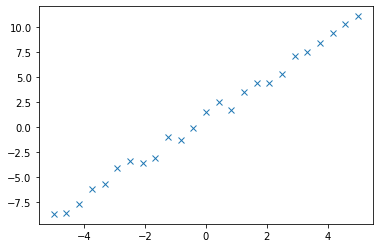

In [2]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
## make observations.
x_obs = np.linspace(-5,5,25)
y_obs = 2.*x_obs + 1. + scp.random.normal(loc=0,scale=0.5,size=25)
plt.plot(x_obs,y_obs,'x')

Define a model that represents the data. This model may also use simulation inputs and outputs.

In [1]:
def Model(x,a,b):
    y = a*x+b
    return y

In this case, the model and the observation model match, so the purpose is to estimate the parameters when the observation data was created.

The steps for kernel ABC are as follows:
1. Generate parameters $\{a_i,b_i\}_{i=1}^N$ from prior distribution $\pi$.
2. Generate simulation data according to the parameters $\hat{y}_{\rm sim} \leftarrow {\rm Model}(x_{\rm obs},a,b);\,\,a,b \sim \pi$.
3. Apply conditional kernel mean by kernel ridge calculation.
4. Calculate the expected value from the obtained post-kernel mean.
5. A sample is taken from the obtained post-kernel mean.

### 1. Generate parameters

In [3]:
#The first and second dimensions of para correspond to a and b, respectively.
para = scp.random.uniform(0, 5, (300, 2))  

In [ ]:
import seaborn as sns

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.kdeplot(x=para[:, 0], y=para[:, 1], ax=ax)
sns.scatterplot(x=para[:,0], y=para[:, 1], ax=ax)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_title('prior samples')

NameError: name 'sns' is not defined

### 2. Generate simulation data according to the parameters

In [ ]:
y_sim = []
for a,b in para:
    y_sim.append(Model(x_obs,a,b))
y_sim = np.array(y_sim)

In [ ]:
y_sim.shape,para.shape

The parameter sample size (100) and the y_sim sample size (100) must be the same.

### 3. Apply conditional kernel mean by kernel ridge calculation.

In [ ]:
import sys
sys.path.append('../')  # to load kernelmtd
from nukernelmtd import KernelABC
from nukernelmtd.kernel import GaussKernel
from nukernelmtd.utils import Bandwidth

In [52]:
bw = Bandwidth(data=y_sim,method='scott')

In [90]:
KBC = KernelABC(data=y_sim,para=para,kernel=GaussKernel(sigma=bw.bandwidth), epsilon=0.1)

Gaussian kernel `sigma` is the bandwidth. This is a hyperparameter. In most cases, you can use the bandwidth estimated by the Bandwidth method.
Something like a distance scale when comparing y.
The `sigma` is roughly determined by determining the distance $\rho$ and tolerance $\epsilon$ between statistics in ABC calculation.

In [91]:
# the shape of y_obs should be (1, 20). Because the shape of y_sim is (n_samples, 20).
np.array([y_obs])

array([[-8.71412209, -8.61141311, -7.72466512, -6.20868504, -5.69985545,
        -4.14283972, -3.45723649, -3.56796067, -3.0936377 , -1.03077736,
        -1.27294296, -0.11085545,  1.49463735,  2.51476506,  1.74273174,
         3.48764375,  4.38617316,  4.37936011,  5.2711473 ,  7.06543801,
         7.51011049,  8.40925078,  9.42969062, 10.31452208, 11.08611812]])

In [92]:
KBC.conditioning(obs=np.array([y_obs]))

### 4. Calculate the expected value from the obtained post-kernel mean.

In [93]:
EAP = KBC.eap

### 5. A sample is taken from the obtained post-kernel mean.

In [94]:
from nukernelmtd import KernelMean
from nukernelmtd.sampling import KernelHerding
from nukernelmtd.utils import sample_clipper

You have to design the kernel for parameter.
The sigma was set to 1.0.    
This depends on the scale of the parameters, if you want to use a different scale for each parameter, define a covariance. 

In [95]:
# KM_post = KernelMean(data=KBC.para, kernel=GaussKernel(covariance=np.diag([1.,1.])), weights=KBC.weights)
KM_post = KBC.posterior_kernel_mean(kernel=GaussKernel(covariance=np.diag([1.,1.])))

Visualize kernel mean. It can be done because it is two-dimensional data.

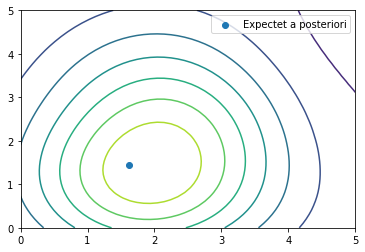

In [96]:
X = np.linspace(0,5,50)
Y = np.linspace(0,5,50)
XX,YY = np.meshgrid(X,Y)
z = KM_post.kde(np.c_[XX.ravel(), YY.ravel()])
plt.contour(XX,YY,z.reshape(50,50))
plt.scatter(EAP[0,0],EAP[0,1],label='Expectet a posteriori')
plt.legend()

In [97]:
KH = KernelHerding(KM_post)

In [98]:
supersamples = KH.sampling(100,max_trial=5,derivatives=True)
clipped_samples, _ = sample_clipper(supersamples,np.array([[0,5],[0,5]]))  #Used to clip out-of-range samples.
KM_supersamples = KernelMean(data=supersamples,kernel=GaussKernel(covariance=np.diag([1.,1.])))

KernelHerding: 100%|██████████| 100/100 [00:13<00:00,  7.60it/s, param:[2.55868391 2.35306586]]


plotting supersamples (samples from kernel mean by kernel herding)

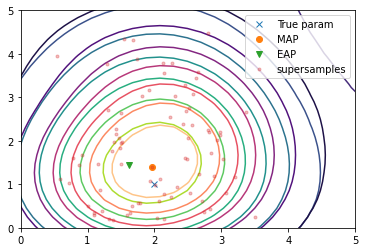

In [99]:
X = np.linspace(-2,8,50)
Y = np.linspace(-2,8,50)
XX,YY = np.meshgrid(X,Y)
z = KM_post.kde(np.c_[XX.ravel(), YY.ravel()])
plt.contour(XX,YY,z.reshape(50,50))
z_super = KM_supersamples.kde(np.c_[XX.ravel(), YY.ravel()])
plt.contour(XX,YY,z_super.reshape(50,50),cmap='magma')

plt.plot(2,1,'x',label='True param')
plt.plot(clipped_samples[0,0],clipped_samples[0,1],'o',label='MAP')
plt.plot(EAP[0,0],EAP[0,1],'v',label='EAP')
plt.plot(clipped_samples[:,0],clipped_samples[:,1],'.',alpha=0.3,label='supersamples')
plt.xlim(0,5)
plt.ylim(0,5)
plt.legend()

**Kernel-ABC is able to estimate the parameters that match obesrvation.**

### Calculate the 2nd moment using a kernel trick.

$$
\def\bra#1{\mathinner{\left\langle{#1}\right|}}
\def\ket#1{\mathinner{\left|{#1}\right\rangle}}
\def\braket#1#2{\mathinner{\left\langle{#1},#2\right\rangle}}
$$

Various expected values ​​are expressed in the kernel as follows.   
\begin{eqnarray}
    E_{\theta\sim\pi}[f(\theta)] &=& \braket{f}{m_\pi} \\
                                 &=& \braket{f(\cdot)}{\sum_{i=1}^N w_i k(\cdot, \theta_i)} \\
                                 &=& \sum_{i=1}^N w_i f(\theta_i)
\end{eqnarray}   
Now, substitute the equation of the second moment into f.   


\begin{eqnarray}
    E_{\theta\sim\pi}[V(\theta)] = \sum_{i=1}^N w_i (\theta_i - \bar{\theta})^2 \simeq \sum_{i=1}^N w_i (\theta_i - \theta_{EAP})^2
\end{eqnarray}

In [100]:
w = KBC.weights
#w[w<0]=0

In [111]:
print(f'Estimated variance by kernel trick:{np.average((KBC.para - KBC.eap)**2, axis=0, weights=KBC.weights)}')
print(f'calculated variance with supersamples:{np.std(clipped_samples, axis=0)**2}')


Estimated variance by kernel trick:[0.43136188 1.38455698]
calculated variance with supersamples:[0.49927166 1.39696028]
